In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.chdir(r"/content/gdrive/My Drive/Arineo/Hunderassen")

Mounted at /content/gdrive


> ## Daten vorbereiten
> #### Herunterladen eines Datensatses mit Bildern von Hunderassen



In [ ]:
import requests

url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
r = requests.get(url, allow_redirects=True)
open('Daten/Hundebilder.tar', 'wb').write(r.content)

793579520

> #### Entpacken der Daten



In [ ]:
import tarfile

tarfile_Hundebilder = tarfile.open('Daten/Hundebilder.tar')
tarfile_Hundebilder.extractall('Daten')

> #### Auflisten ausgewählter Hunderassen-Ordner



In [ ]:
import os

selected_breeds = ['Chihuahua', 'golden_retriever', 'miniature_poodle', \
                   'cocker_spaniel', 'beagle', 'basset', \
                   'Appenzeller', 'standard_schnauzer', \
                   'whippet', 'vizsla']
list_breeds_folders = [f.path for f in os.scandir('Daten/Images') \
                       if f.is_dir() and f.name[10:] in selected_breeds]

print('Anzahl an ausgewählten Hunderassen: ', len(list_breeds_folders))
print('Pfade mit Bildern: ')
for path in list_breeds_folders:
    print(path)

Anzahl an ausgewählten Hunderassen:  10
Pfade mit Bildern: 
Daten/Images/n02085620-Chihuahua
Daten/Images/n02088238-basset
Daten/Images/n02088364-beagle
Daten/Images/n02091134-whippet
Daten/Images/n02097209-standard_schnauzer
Daten/Images/n02099601-golden_retriever
Daten/Images/n02100583-vizsla
Daten/Images/n02102318-cocker_spaniel
Daten/Images/n02107908-Appenzeller
Daten/Images/n02113712-miniature_poodle


> #### Einlesen der Bilder und Labels und als Dictionary speichern



In [ ]:
import numpy as np
from PIL import Image
import pickle

imsize = (256,256)
i = 0
y = []
for breed_folder in list_breeds_folders:
    dog_breed = breed_folder.split('/')[-1][10:]
    print(dog_breed)
    list_ims_paths = [f.path for f in os.scandir(breed_folder) \
                      if f.name.endswith('.jpg')]
    for impath in list_ims_paths:
        im = np.array(Image.open(impath).resize(imsize).convert('RGB'))
        im = np.expand_dims(im, axis=0)
        if i == 0:
            X = im
        else:
            X = np.append(X, im, axis=0)
        y.append(dog_breed)
        i += 1
y = np.array(y)

data = {'X': X, 
        'y': y}

with open('Daten/selected_data.pkl', 'wb') as file:
    pickle.dump(data, file)

Chihuahua
basset
beagle
whippet
standard_schnauzer
golden_retriever
vizsla
cocker_spaniel
Appenzeller
miniature_poodle


> #### Das Dictionary laden



In [2]:
import pickle
with open('Daten/selected_data.pkl', 'rb') as file:
    data = pickle.load(file)
X = data['X']
y = data['y']

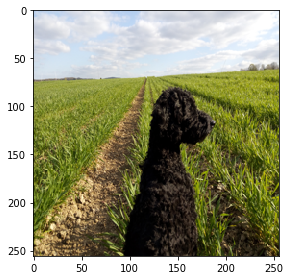

In [3]:
from skimage import io
io.imshow(X[0])

> #### Datensatz aufteilen in Trainings- Test- und Validierungsdaten



In [4]:
from sklearn.model_selection import train_test_split

indices = [i for i in range(0,X.shape[0])]
train_main, test = train_test_split(indices, 
                                    test_size=0.2, 
                                    random_state=42, 
                                    stratify=y)
train, val = train_test_split(train_main, 
                              test_size=0.2, 
                              random_state=42, 
                              stratify=y[train_main])

> #### Labels one-hot-codieren



In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class LabelTransformer():

    def __init__(self, y):
        self.le = LabelEncoder()
        self.le.fit(y)
        y_num = self.le.transform(y)
        self.oh_enc = OneHotEncoder(sparse=False)
        self.oh_enc.fit(y_num.reshape(-1,1))
    
    def transform(self, y):
        if len(y.shape) == 0:
            y = np.expand_dims(y, axis = 0)
        y_num = self.le.transform(y)
        y_oh = self.oh_enc.transform(y_num.reshape(-1,1))
        return y_oh

    def inverse_transform(self, y_oh):
        if len(y_oh.shape) == 0:
            y_oh = np.expand_dims(y_oh, axis = 0)
        y_num = self.oh_enc.inverse_transform(y_oh)[:,0]
        y = self.le.inverse_transform(y_num)
        return y

leTrans = LabelTransformer(y)

In [6]:
# Testen der Label-Transformation
print('Originallabel: ', y[[0,499]])
y_oh = leTrans.transform(y[[0,499]])
print('One-Hot-Codiert: ', y_oh)
y_recovered = leTrans.inverse_transform(y_oh)
print('Wiederhergestellt: ', y_recovered)

Originallabel:  ['miniature_poodle' 'beagle']
One-Hot-Codiert:  [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Wiederhergestellt:  ['miniature_poodle' 'beagle']



> ### Generator erstellen um stapelweise Bilder und Labels zu erhalten



In [7]:
def train_test_generator(X, 
                         y, 
                         leTrans, 
                         batch_size, 
                         transform=None, 
                         shuffle=True):
    y_oh = leTrans.transform(y)
    i = 0
    indices = np.arange(0,X.shape[0])
    while True:
        if i == 0:
            if shuffle:
                np.random.shuffle(indices)
        batch_indices = indices[i:i+batch_size]
        batch_images = np.copy(X[batch_indices])
        if transform is not None:
            for j in range(0, batch_images.shape[0]): 
                batch_images[j] = transform(batch_images[j])
        batch_images = batch_images/255
        if y is not None: 
            batch_labels = y_oh[batch_indices]
            yield batch_images, batch_labels
        else:
            yield batch_images
        i = i + batch_size
        if (i + batch_size) > indices.shape[0]:
            i = 0

Stapelform:  (32, 256, 256, 3)
1. Label im Stapel:
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] ['miniature_poodle']
Minimaler Intensitätswert:  0.0  Maximaler Intensitätswert:  1.0


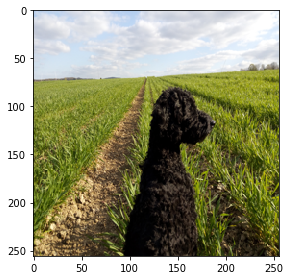

In [8]:
from skimage import io

gen = train_test_generator(X, y, leTrans, 32, shuffle=False)
im_batch, y_batch = next(gen)
print('Stapelform: ', im_batch.shape)
print('1. Label im Stapel:')
print(y_batch[0], leTrans.inverse_transform(y_batch[0:1]))
print('Minimaler Intensitätswert: ', np.min(im_batch[0]), \
      ' Maximaler Intensitätswert: ', np.max(im_batch[0]))
io.imshow(im_batch[0])

> ### Funktion zum Trainieren des CNNs

In [9]:
import json

def train_model(model, 
                batch_size, 
                epochs, 
                X_train, 
                X_val, 
                y_train, 
                y_val, 
                leTrans, 
                savepath='logs/best_model.hdf5', 
                savepath_hist='logs/history.json', 
                transform_train=None, 
                transform_val=None, 
                save_weights=True, 
                save_hist=True):
    
    print('X_train.shape = '+str(X_train.shape)+ \
          '   X_val.shape = '+str(X_val.shape))
    log_dir_weights = savepath[:-len(savepath.split('/')[-1])-1]
    log_dir_hist = savepath_hist[:-len(savepath_hist.split('/')[-1])-1]
    if not os.path.exists(log_dir_weights):
      os.makedirs(log_dir_weights)
    if not os.path.exists(log_dir_hist):
      os.makedirs(log_dir_hist)
    num_train_samples = X_train.shape[0]
    num_val_samples = X_val.shape[0]
    train_steps = np.floor(num_train_samples/batch_size).astype(int)
    validation_steps = num_val_samples

    train_gen = train_test_generator(X_train, 
                                     y_train, 
                                     leTrans, 
                                     batch_size, 
                                     transform=transform_train, 
                                     shuffle=True)
    val_gen = train_test_generator(X_val, 
                                   y_val, 
                                   leTrans, 
                                   1, 
                                   transform=transform_val, 
                                   shuffle=False)
    history = {"train_loss": [], 
               "train_accuracy": [], 
               "val_loss": [], 
               "val_accuracy": [], 
               "best_epoch": 0}
    # Initialisieren der besten Epoche, Gewichte, Erkennungsgenauigkeiten
    # best_epoch: die Epoche mit der höchsten Validierungsgenauigkeit
    best_epoch = 0
    best_weights = None
    best_val_loss = np.Inf
    best_val_accuracy = 0
    best_train_accuracy = 0
    best_train_loss = np.Inf
    for epoch in range(0, epochs):
        train_loss, val_loss , train_accuracy, val_accuracy  = [], [], [], []
        # Training
        for step in range(0, train_steps):
            X_train_batch, y_train_batch = next(train_gen)
            metrics = model.train_on_batch(X_train_batch, y_train_batch)
            train_loss.append(metrics[0])
            train_accuracy.append(metrics[1])
        mean_train_loss = np.mean(np.asarray(train_loss))
        mean_train_accuracy = np.mean(np.asarray(train_accuracy))
        history["train_loss"].append(mean_train_loss)
        history["train_accuracy"].append(mean_train_accuracy)
        # Validierung
        for step in range(0, validation_steps):
            X_val_batch, y_val_batch = next(val_gen)
            metrics = model.test_on_batch(X_val_batch, y_val_batch)
            val_loss.append(metrics[0])
            val_accuracy.append(metrics[1])
        mean_val_loss = np.mean(np.asarray(val_loss))
        mean_val_accuracy = np.mean(np.asarray(val_accuracy))
        history["val_loss"].append(mean_val_loss)
        history["val_accuracy"].append(mean_val_accuracy)

        print("epoch: "+str(epoch)+",   train_loss: "+str(round(mean_train_loss, \
                                                                4))+
              ",   train_accuracy: "+str(round(mean_train_accuracy, 4))+\
              ",   val_loss: "+
              str(round(mean_val_loss, 4))+",   val_accuracy: "+
              str(round(mean_val_accuracy, 4)))
        
        # Speichern der besten Gewichte
        if np.less(mean_val_loss, best_val_loss):
            history["best_epoch"] = epoch
            best_val_accuracy = np.copy(mean_val_accuracy)
            best_val_loss = np.copy(mean_val_loss)
            best_train_accuracy = np.copy(mean_train_accuracy)
            best_train_loss = np.copy(mean_train_loss)
            best_weights = model.get_weights()
            
            print("save best weights")
            model.save_weights(savepath)
        
        # History speichern
        json.dump(history, open(savepath_hist, 'w'))
    
    # Laden der besten Gewichte
    model.set_weights(best_weights)
    return history

> ### Ein eigenes CNN erstellen

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, \
                                    MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam

In [11]:
def build_custom_model(imsize, num_classes):
    input_shape = imsize + (3,)
    model = Sequential()
    model.add(InputLayer(input_shape=(256,256,3)))
    # 1. Convolutional Layer
    model.add(Conv2D(3, (3,3), padding='same', activation='relu'))
    # Max-Pooling Layer
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    # 2. Convolutional Layer
    model.add(Conv2D(5, (3,3), padding='same', activation='relu'))
    # Max-Pooling Layer
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    # 3. Convolutional Layer
    model.add(Conv2D(15, (3,3), padding='same', activation='relu'))
    # Max-Pooling Layer
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    # 4. Convolutional Layer
    model.add(Conv2D(30, (3,3), padding='same', activation='relu'))
    # Max-Pooling Layer
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
    # Aufreihen der Pixel der letzten Feature Map
    model.add(Flatten())
    # Vollständig verbundener Layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model

In [12]:
tf.keras.backend.clear_session()
model = build_custom_model(imsize=(256,256), num_classes=10)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 3)       84        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 5)       140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 15)        690       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 30)        4

> ### Das CNN trainieren

In [13]:
tf.keras.backend.clear_session()
model = build_custom_model(imsize=(256,256), num_classes=10)
history = train_model(model = model, 
                      batch_size = 32, 
                      epochs = 20, 
                      X_train = X[train], 
                      X_val = X[val], 
                      y_train = y[train], 
                      y_val = y[val], 
                      leTrans = leTrans)

X_train.shape = (1044, 256, 256, 3)   X_val.shape = (262, 256, 256, 3)
epoch: 0,   train_loss: 2.3022,   train_accuracy: 0.1084,   val_loss: 2.2886,   val_accuracy: 0.1221
save best weights
epoch: 1,   train_loss: 2.2557,   train_accuracy: 0.1553,   val_loss: 2.2392,   val_accuracy: 0.1603
save best weights
epoch: 2,   train_loss: 2.1085,   train_accuracy: 0.2246,   val_loss: 2.252,   val_accuracy: 0.1718
epoch: 3,   train_loss: 1.9057,   train_accuracy: 0.3145,   val_loss: 2.2879,   val_accuracy: 0.1718
epoch: 4,   train_loss: 1.6199,   train_accuracy: 0.415,   val_loss: 2.4908,   val_accuracy: 0.1794
epoch: 5,   train_loss: 1.2956,   train_accuracy: 0.5645,   val_loss: 3.0041,   val_accuracy: 0.1718
epoch: 6,   train_loss: 1.019,   train_accuracy: 0.6514,   val_loss: 3.2324,   val_accuracy: 0.1565
epoch: 7,   train_loss: 0.7211,   train_accuracy: 0.7715,   val_loss: 3.6964,   val_accuracy: 0.1756
epoch: 8,   train_loss: 0.4582,   train_accuracy: 0.876,   val_loss: 4.5738,   val_accur

In [18]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history['train_accuracy']
    val_acc = history['val_accuracy']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.rc('legend', fontsize=14)
    plt.figure(figsize=(7,5))
    plt.plot(epochs, acc, 'bo', label='Trainingsdaten')
    plt.plot(epochs, val_acc, 'r', label='Validierungsdaten')
    plt.xlabel('Epochen', {'fontsize': 16})
    plt.ylabel('Genauigkeit', {'fontsize': 16})

    plt.legend()

    plt.figure(figsize=(7,5))
    plt.plot(epochs, loss, 'bo', label='Trainingsdaten')
    plt.plot(epochs, val_loss, 'r', label='Validierungsdaten')
    plt.xlabel('Epochen', {'fontsize': 16})
    plt.ylabel('Verlust', {'fontsize': 16})
    plt.legend()

    plt.show()

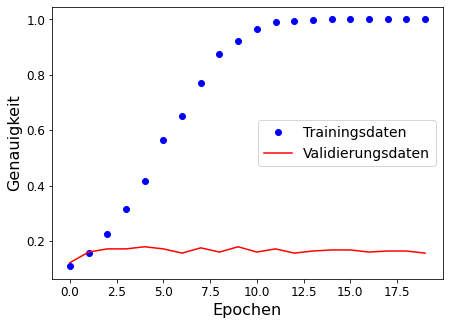

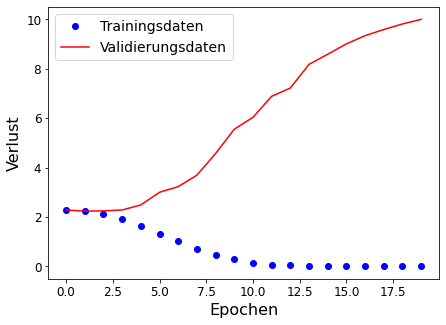

In [17]:
plot_history(history)

> ### Augmentierung

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
import matplotlib.pyplot as plt
import albumentations as A

def augment_image(im):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5), 
        A.RandomBrightnessContrast(brightness_limit=0.2, 
                                   contrast_limit=0.2,
                                   p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, 
                           scale_limit=0.2, 
                           rotate_limit=30, 
                           p=0.5), 
        A.OpticalDistortion(distort_limit=0.5, 
                            shift_limit=0.05, 
                            p=0.5), 
        A.GaussNoise(var_limit=(10.0, 50.0), 
                     mean=0, 
                     per_channel=True, 
                     always_apply=False, 
                     p=0.5), 
        A.CoarseDropout(max_holes=12, 
                        max_height=40, 
                        max_width=40, 
                        min_holes=1, 
                        min_height=10, 
                        min_width=10, 
                        p=1.0)
    ])
    im = np.copy(im)
    transformed = transform(image=im)
    transformed_image = transformed["image"]
    return transformed_image
    
im = np.copy(X[0])
fig = plt.figure(figsize=(22, 22))
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    if i == 0:
        ax.imshow(im)
    else:
        transformed_image = augment_image(im)
        ax.imshow(transformed_image)

Output hidden; open in https://colab.research.google.com to view.

> #### Erneutes Trainieren mit Augmentierung

In [ ]:
tf.keras.backend.clear_session()
model = build_custom_model(imsize=(256,256), num_classes=10)
history = train_model(model = model, 
                      batch_size = 32, 
                      epochs = 40, 
                      X_train = X[train], 
                      X_val = X[val], 
                      y_train = y[train], 
                      y_val = y[val], 
                      leTrans = leTrans, 
                      transform_train = augment_image)

X_train.shape = (1044, 256, 256, 3)   X_val.shape = (262, 256, 256, 3)
epoch: 0,   train_loss: 2.3028,   train_accuracy: 0.1025,   val_loss: 2.2933,   val_accuracy: 0.1489
save best weights
epoch: 1,   train_loss: 2.286,   train_accuracy: 0.1455,   val_loss: 2.2423,   val_accuracy: 0.1527
save best weights
epoch: 2,   train_loss: 2.2202,   train_accuracy: 0.1611,   val_loss: 2.1589,   val_accuracy: 0.2137
save best weights
epoch: 3,   train_loss: 2.1555,   train_accuracy: 0.1836,   val_loss: 2.1418,   val_accuracy: 0.2061
save best weights
epoch: 4,   train_loss: 2.1192,   train_accuracy: 0.2109,   val_loss: 2.1378,   val_accuracy: 0.1756
save best weights
epoch: 5,   train_loss: 2.1295,   train_accuracy: 0.2373,   val_loss: 2.1121,   val_accuracy: 0.2328
save best weights
epoch: 6,   train_loss: 2.0749,   train_accuracy: 0.2471,   val_loss: 2.0907,   val_accuracy: 0.2557
save best weights
epoch: 7,   train_loss: 2.057,   train_accuracy: 0.2305,   val_loss: 2.1106,   val_accuracy: 0.24

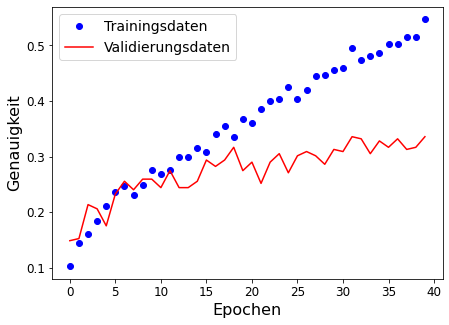

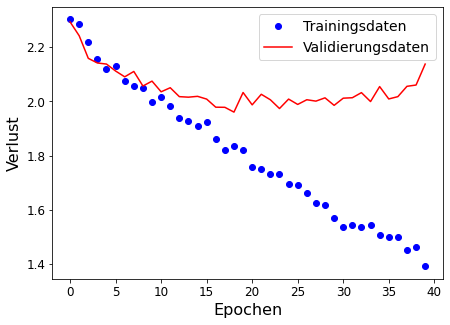

In [ ]:
plot_history(history)

> ### Transfer learning
>#### Ein vortrainiertes CNN erstellen

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout

def build_VGG16_model(imsize=(256,256), dropout_rate=0.5, trainable_layers=-7, num_classes=10):
    input_shape = imsize + (3,)
    conv_base = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=input_shape)
    single_model = Sequential()
    for layer in conv_base.layers:
        single_model.add(layer)
    single_model.add(Flatten(name="conv_base_Flatten"))
    single_model.add(Dropout(dropout_rate))
    single_model.add(Dense(256, activation='relu'))
    single_model.add(Dropout(dropout_rate))
    single_model.add(Dense(num_classes, activation='softmax'))
    for layer in single_model.layers[:]:
        layer.trainable = False
    for layer in single_model.layers[trainable_layers:]:
        layer.trainable = True
    single_model.compile(optimizer=Adam(), 
                         loss='categorical_crossentropy',
                         metrics=['acc'])
    return single_model

In [ ]:
tf.keras.backend.clear_session()
model = build_VGG16_model(num_classes=len(np.unique(y)), trainable_layers=-3)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       2

> #### Vortrainiertes CNN trainieren

In [ ]:
history = train_model(model = model, 
                      batch_size = 32, 
                      epochs = 100, 
                      X_train = X[train], 
                      X_val = X[val], 
                      y_train = y[train], 
                      y_val = y[val], 
                      leTrans = leTrans, 
                      transform_train = augment_image, 
                      savepath='logs/best_model.hdf5', 
                      savepath_hist='logs/history.json')

X_train.shape = (1044, 256, 256, 3)   X_val.shape = (262, 256, 256, 3)
epoch: 0,   train_loss: 3.1566,   train_accuracy: 0.1279,   val_loss: 2.2551,   val_accuracy: 0.2099
save best weights
epoch: 1,   train_loss: 2.2654,   train_accuracy: 0.1562,   val_loss: 2.1523,   val_accuracy: 0.2176
save best weights
epoch: 2,   train_loss: 2.2118,   train_accuracy: 0.165,   val_loss: 2.1314,   val_accuracy: 0.2786
save best weights
epoch: 3,   train_loss: 2.2112,   train_accuracy: 0.1934,   val_loss: 2.1089,   val_accuracy: 0.2786
save best weights
epoch: 4,   train_loss: 2.1709,   train_accuracy: 0.1963,   val_loss: 2.077,   val_accuracy: 0.3168
save best weights
epoch: 5,   train_loss: 2.1381,   train_accuracy: 0.1982,   val_loss: 2.0689,   val_accuracy: 0.3282
save best weights
epoch: 6,   train_loss: 2.1496,   train_accuracy: 0.2041,   val_loss: 1.9895,   val_accuracy: 0.2786
save best weights
epoch: 7,   train_loss: 2.1141,   train_accuracy: 0.2178,   val_loss: 1.974,   val_accuracy: 0.267

In [ ]:
tf.keras.backend.clear_session()
model = build_VGG16_model(num_classes=len(np.unique(y)), trainable_layers=-7)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       2

In [ ]:
history = train_model(model = model, 
                      batch_size = 32, 
                      epochs = 50, 
                      X_train = X[train], 
                      X_val = X[val], 
                      y_train = y[train], 
                      y_val = y[val], 
                      leTrans = leTrans, 
                      transform_train = augment_image, 
                      savepath='logs/best_model.hdf5', 
                      savepath_hist='logs/history.json')

X_train.shape = (1044, 256, 256, 3)   X_val.shape = (262, 256, 256, 3)
epoch: 0,   train_loss: 2.7191,   train_accuracy: 0.125,   val_loss: 2.1092,   val_accuracy: 0.3321
save best weights
epoch: 1,   train_loss: 2.1069,   train_accuracy: 0.2246,   val_loss: 1.7391,   val_accuracy: 0.3702
save best weights
epoch: 2,   train_loss: 1.8866,   train_accuracy: 0.3223,   val_loss: 1.5457,   val_accuracy: 0.4504
save best weights
epoch: 3,   train_loss: 1.6995,   train_accuracy: 0.3906,   val_loss: 1.608,   val_accuracy: 0.4885
epoch: 4,   train_loss: 1.6031,   train_accuracy: 0.4277,   val_loss: 1.4314,   val_accuracy: 0.5115
save best weights
epoch: 5,   train_loss: 1.5023,   train_accuracy: 0.4775,   val_loss: 1.4434,   val_accuracy: 0.4656
epoch: 6,   train_loss: 1.4732,   train_accuracy: 0.4814,   val_loss: 1.32,   val_accuracy: 0.5611
save best weights
epoch: 7,   train_loss: 1.3138,   train_accuracy: 0.5332,   val_loss: 1.4204,   val_accuracy: 0.5649
epoch: 8,   train_loss: 1.3538,   t

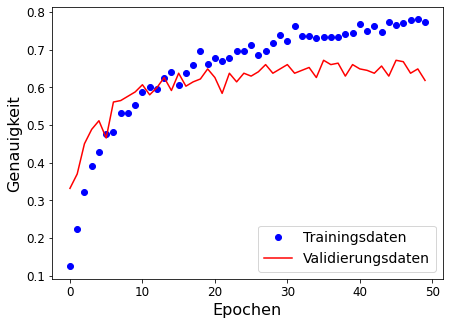

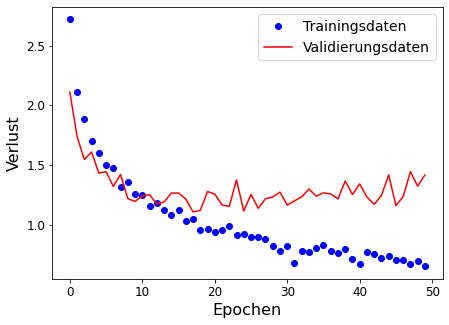

In [ ]:
plot_history(history)

In [ ]:
tf.keras.backend.clear_session()
model = build_VGG16_model(num_classes=len(np.unique(y)), trainable_layers=-7)
model.load_weights('logs/best_model.hdf5')
y_oh = leTrans.transform(y)
test_results = model.evaluate(X[test], y_oh[test])
print("test loss, test acc:", test_results)

11/11 [==============================] - 4s 357ms/step - loss: 95.7615 - acc: 0.5291
test loss, test acc: [95.76148223876953, 0.5290519595146179]
